<a href="https://colab.research.google.com/github/NituB22/DeepFakeDetectionXAI/blob/main/deepFakeDetectionXAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
random.seed(10)

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import PIL
import PIL.Image
from PIL import Image, ImageChops, ImageEnhance
from scipy import ndimage
import tensorflow as tf
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import cv2
import shap


In [ ]:
training_path_original = 'trainingSet_path'
val_path_original = 'validationSet_path'

In [ ]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
training_set_original = train_datagen.flow_from_directory(training_path_original,
                                                 target_size = (180, 180),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True)
val_set_original = val_datagen.flow_from_directory(val_path_original,
                                            target_size = (180, 180),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle=True)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))

Implementing a pre-trained model

In [ ]:

from tensorflow.keras.applications import Xception
base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(180, 180, 3),
    include_top=False,
)

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

In [ ]:
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(2)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                             

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [ ]:
epochs = 10
model.fit(training_set_original, epochs=epochs, validation_data=val_set_original)

Epoch 1/10
3125/3125 [==============================] - 354s 109ms/step - loss: 0.5339 - binary_accuracy: 0.6229 - val_loss: 0.4796 - val_binary_accuracy: 0.6477
Epoch 2/10
3125/3125 [==============================] - 333s 106ms/step - loss: 0.5123 - binary_accuracy: 0.6483 - val_loss: 0.4703 - val_binary_accuracy: 0.6536
Epoch 3/10
3125/3125 [==============================] - 325s 104ms/step - loss: 0.5119 - binary_accuracy: 0.6529 - val_loss: 0.4696 - val_binary_accuracy: 0.6530
Epoch 4/10
3125/3125 [==============================] - 325s 104ms/step - loss: 0.5122 - binary_accuracy: 0.6546 - val_loss: 0.4700 - val_binary_accuracy: 0.6561
Epoch 5/10
3125/3125 [==============================] - 324s 104ms/step - loss: 0.5108 - binary_accuracy: 0.6550 - val_loss: 0.4738 - val_binary_accuracy: 0.6425
Epoch 6/10
3125/3125 [==============================] - 325s 104ms/step - loss: 0.5121 - binary_accuracy: 0.6543 - val_loss: 0.4927 - val_binary_accuracy: 0.6424
Epoch 7/10
3125/3125 [======

Fine-tuning of the entire model

In [ ]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                             

In [ ]:
model.fit(training_set_original, epochs=epochs, validation_data=val_set_original)

Epoch 1/10
3125/3125 [==============================] - 1103s 342ms/step - loss: 0.1954 - binary_accuracy: 0.9155 - val_loss: 0.0924 - val_binary_accuracy: 0.9629
Epoch 2/10
3125/3125 [==============================] - 1083s 347ms/step - loss: 0.0528 - binary_accuracy: 0.9795 - val_loss: 0.0544 - val_binary_accuracy: 0.9784
Epoch 3/10
3125/3125 [==============================] - 1083s 346ms/step - loss: 0.0213 - binary_accuracy: 0.9920 - val_loss: 0.0472 - val_binary_accuracy: 0.9846
Epoch 4/10
3125/3125 [==============================] - 1082s 346ms/step - loss: 0.0097 - binary_accuracy: 0.9964 - val_loss: 0.0480 - val_binary_accuracy: 0.9841
Epoch 5/10
3125/3125 [==============================] - 1082s 346ms/step - loss: 0.0078 - binary_accuracy: 0.9970 - val_loss: 0.0432 - val_binary_accuracy: 0.9866
Epoch 6/10
3125/3125 [==============================] - 1081s 346ms/step - loss: 0.0064 - binary_accuracy: 0.9977 - val_loss: 0.0699 - val_binary_accuracy: 0.9810
Epoch 7/10
3125/3125 [

Testing on the test set

In [ ]:
main_test_path = 'testSet_path'

In [ ]:
test_datagen = ImageDataGenerator()
test_x_dataset = test_datagen.flow_from_directory(main_test_path,
                                            target_size = (180, 180),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle=False)

Found 20000 images belonging to 2 classes.


In [ ]:
test_y_orig_dataset = test_x_dataset.classes
y_pred_orig_prob_dataset = model.predict(test_x_dataset)

625/625 [==============================] - 67s 105ms/step


In [ ]:
y_pred_orig_dataset = np.argmax(y_pred_orig_prob_dataset, axis=1)

In [ ]:
print(classification_report(test_y_orig_dataset, y_pred_orig_dataset))

print(confusion_matrix(test_y_orig_dataset, y_pred_orig_dataset))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10000
           1       0.99      0.99      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000

[[9918   82]
 [ 144 9856]]


Testing on Fake Vs Real Faces (Hard) dataset

In [ ]:
# TEST SET OF 140K REAL AND FAKE FACE DATASET
main_test_path = 'fakeVsRealFacesHardDataset_path'

In [ ]:
test_datagen = ImageDataGenerator()
test_x_dataset = test_datagen.flow_from_directory(main_test_path,
                                            target_size = (180, 180),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle=False)

Found 1289 images belonging to 2 classes.


In [ ]:
test_y_orig_dataset = test_x_dataset.classes
y_pred_orig_prob_dataset = model.predict(test_x_dataset)

41/41 [==============================] - 4s 90ms/step


In [ ]:
y_pred_orig_dataset = np.argmax(y_pred_orig_prob_dataset, axis=1)

In [ ]:
print(classification_report(test_y_orig_dataset, y_pred_orig_dataset))

print(confusion_matrix(test_y_orig_dataset, y_pred_orig_dataset))

              precision    recall  f1-score   support

           0       1.00      0.53      0.69       700
           1       0.64      1.00      0.78       589

    accuracy                           0.74      1289
   macro avg       0.82      0.76      0.73      1289
weighted avg       0.83      0.74      0.73      1289

[[369 331]
 [  1 588]]


In [ ]:
test_path = '26samples_path'

In [ ]:
x_test=[]

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(180,180))

        x_test.append(img_arr)

In [ ]:
test_data=np.array(x_test)

**SHAP** :Explainable AI

In [ ]:
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
classes =  np.unique(test_y_orig)
classes

array([0, 1], dtype=int32)

In [ ]:
class_labels = ["fake","real"]
mapping = dict(zip(classes, class_labels))
mapping

{0: 'fake', 1: 'real'}

In [ ]:

masker = shap.maskers.Image("inpaint_telea", test_data[0].shape)


In [ ]:
explainer = shap.Explainer(model, masker,  output_names=class_labels)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:18, 18.45s/it]               


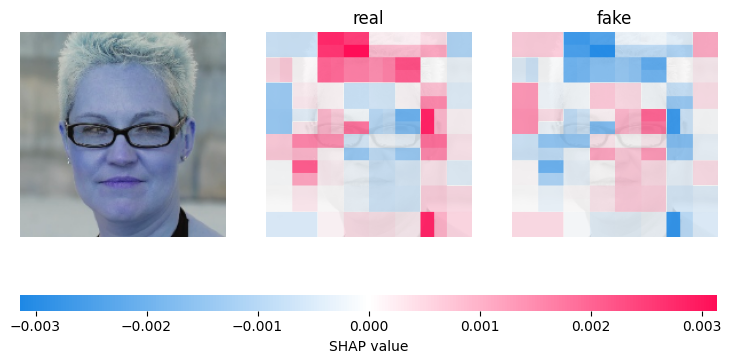

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.63s/it]               


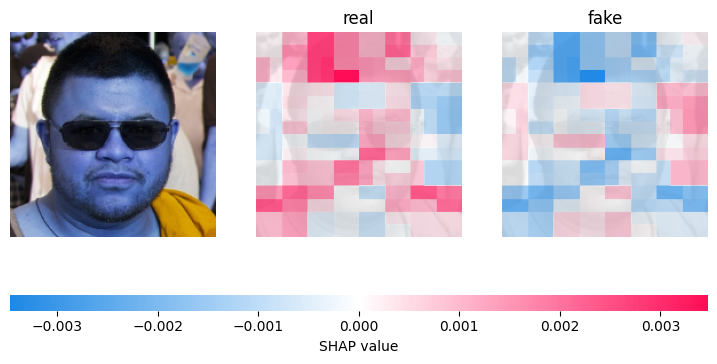

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:16, 16.33s/it]               


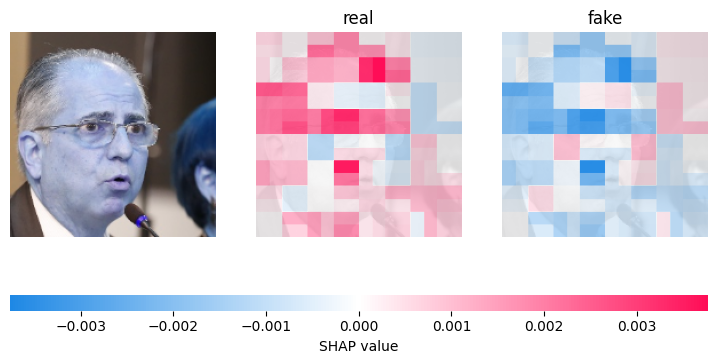

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:16, 16.27s/it]               


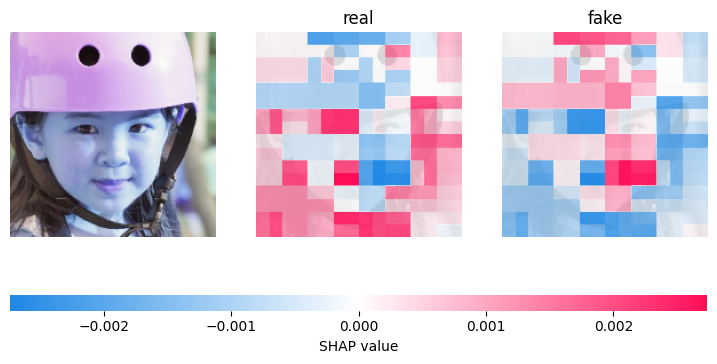

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:16, 16.22s/it]               


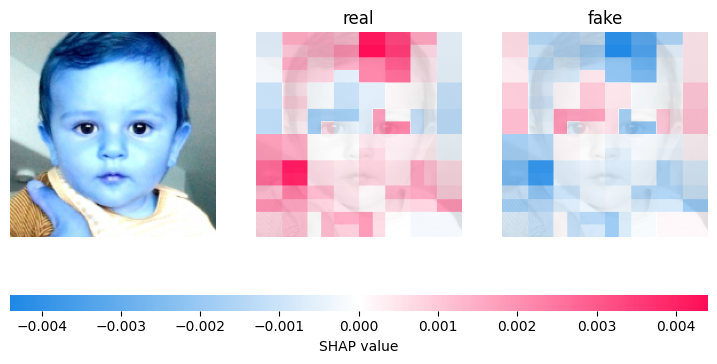

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:17, 17.06s/it]               


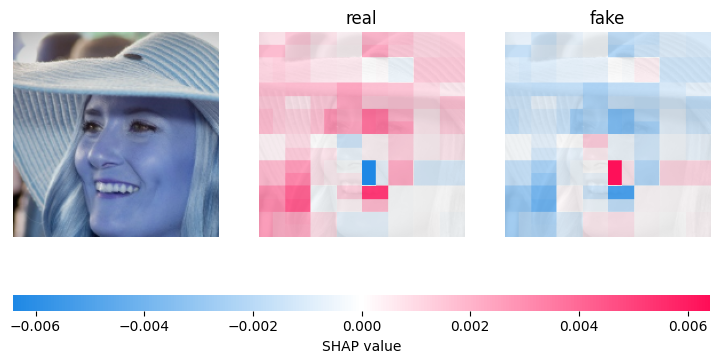

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:16, 16.55s/it]               


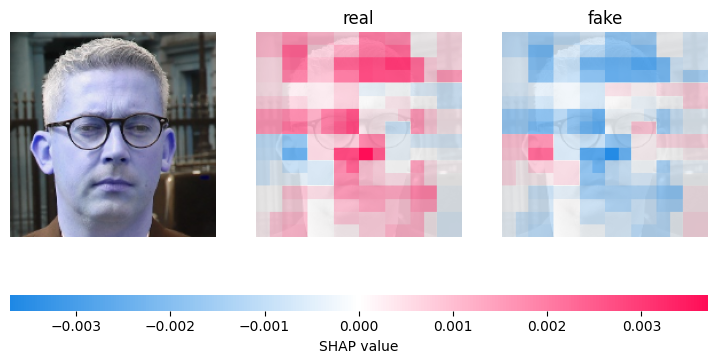

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:16, 16.38s/it]               


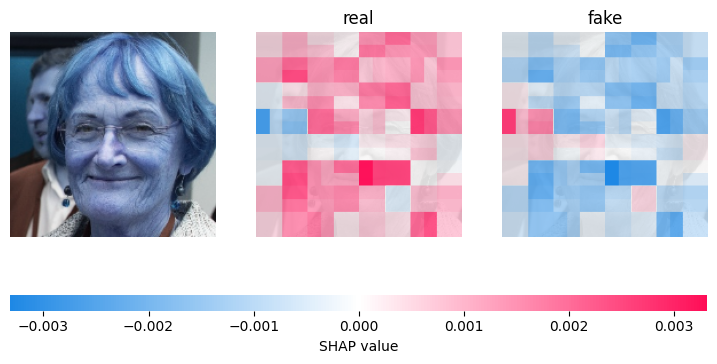

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:16, 16.81s/it]               


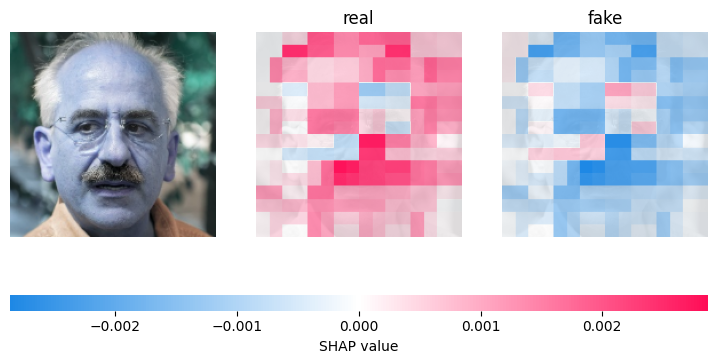

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:16, 16.61s/it]               


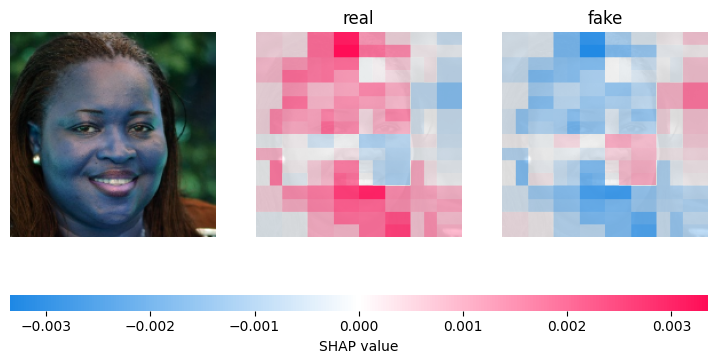

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.72s/it]               


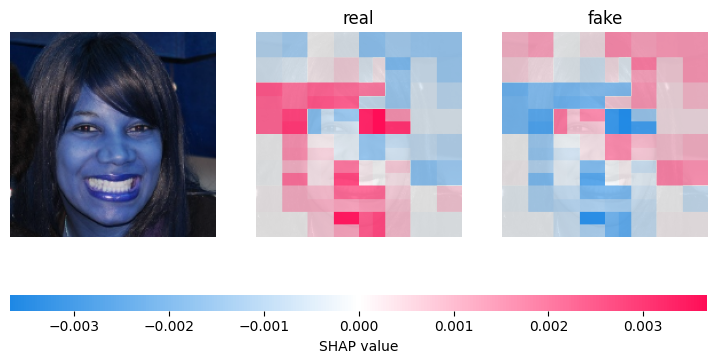

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:16, 16.97s/it]               


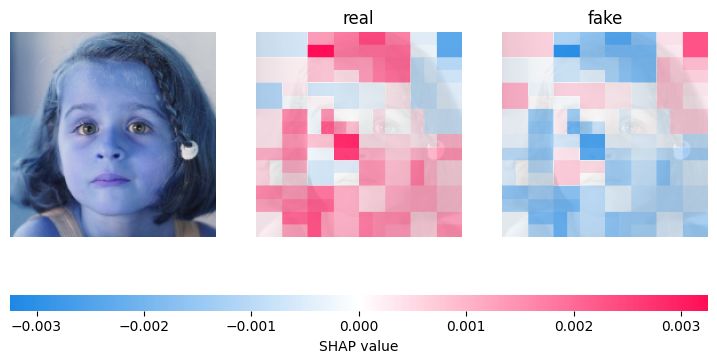

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:16, 16.66s/it]               


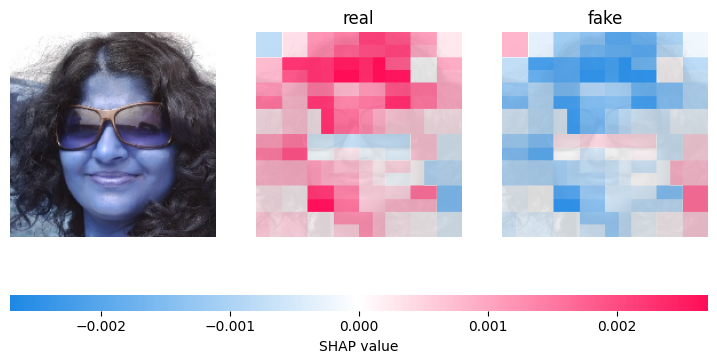

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.69s/it]               


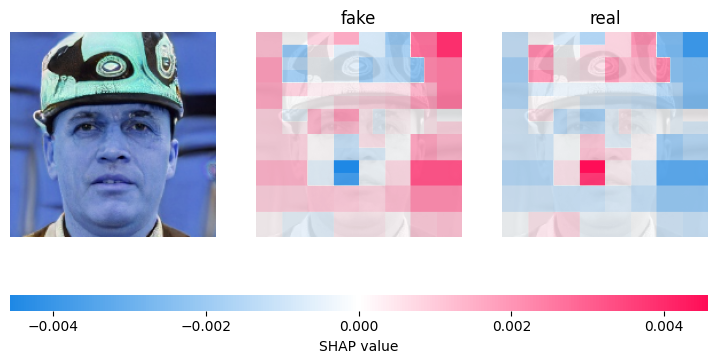

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.50s/it]               


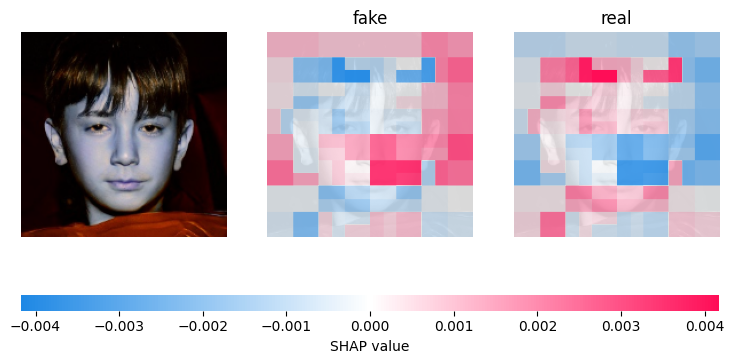

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:16, 16.04s/it]               


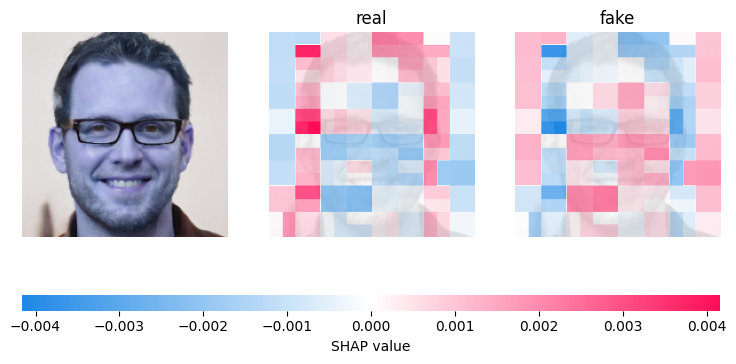

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.48s/it]               


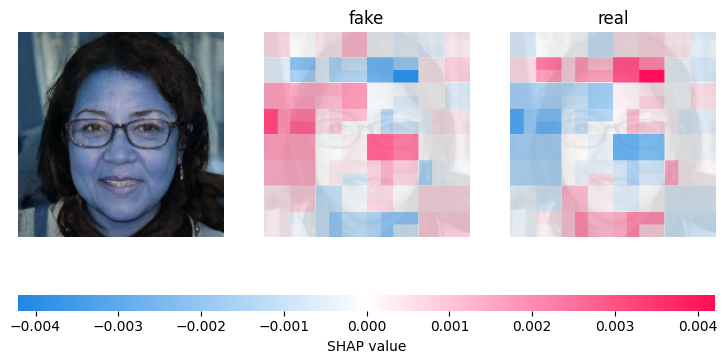

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.18s/it]               


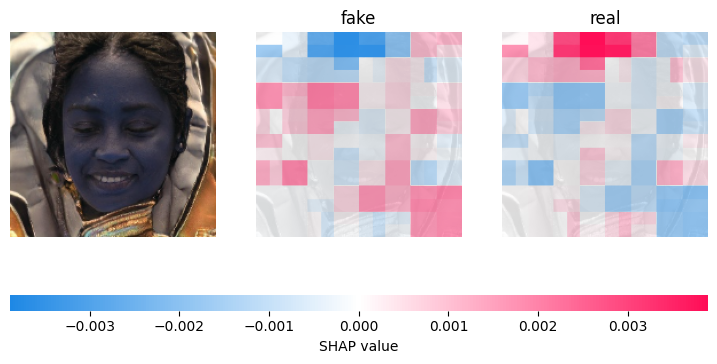

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.12s/it]               


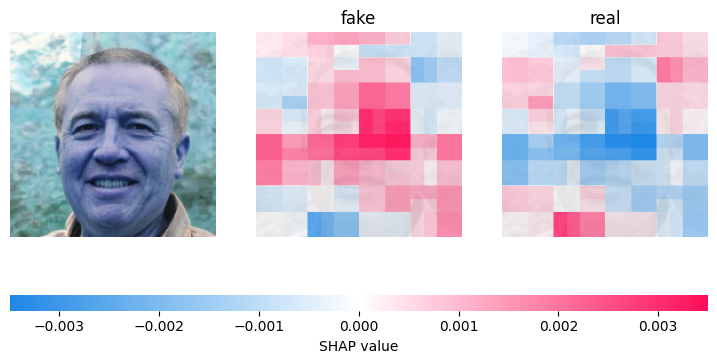

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.52s/it]               


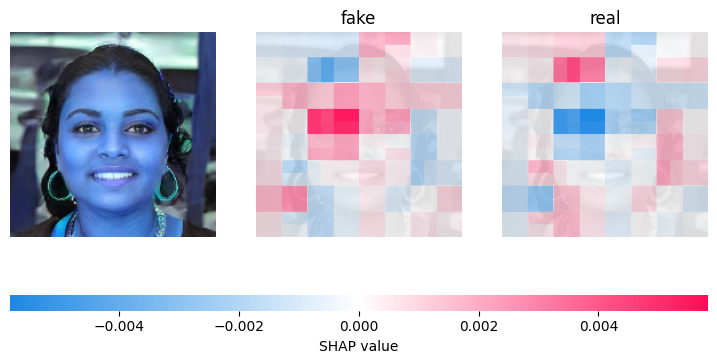

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.11s/it]               


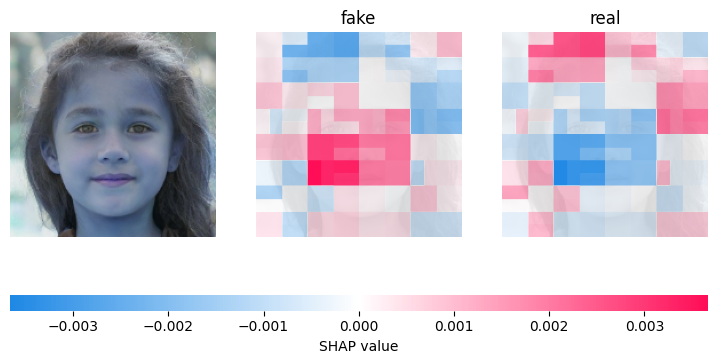

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:16, 16.41s/it]               


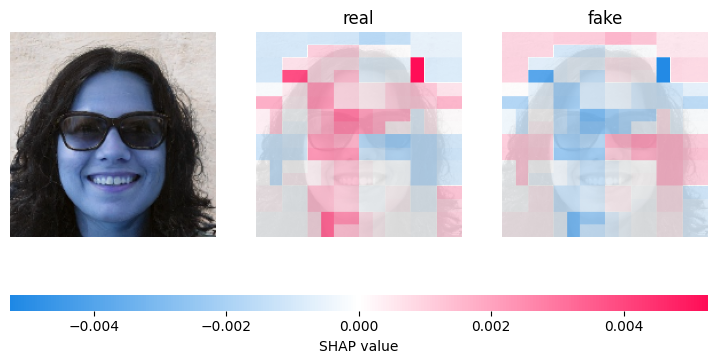

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.83s/it]               


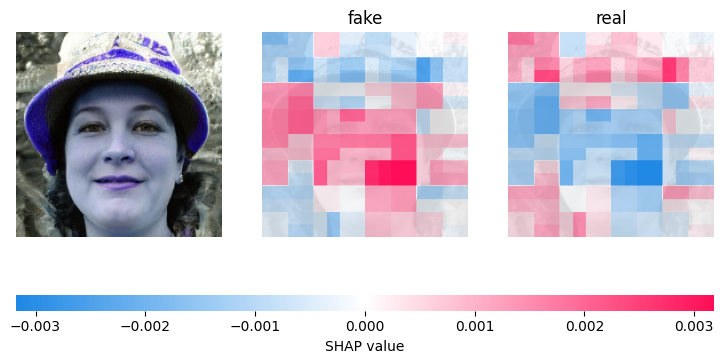

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.85s/it]               


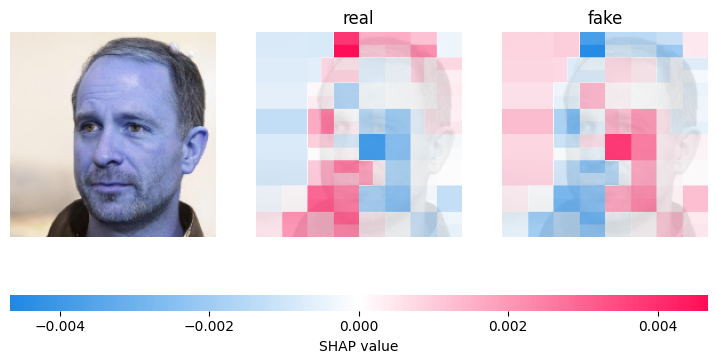

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.29s/it]               


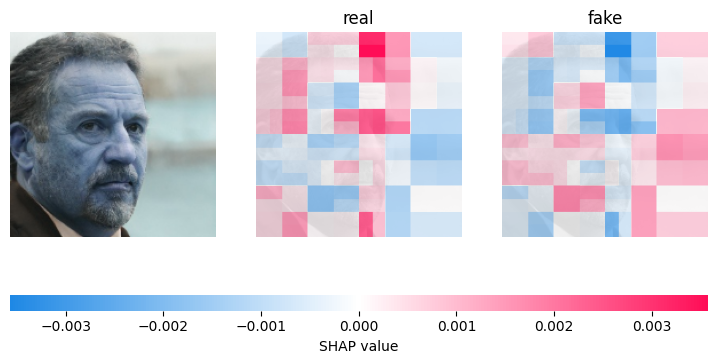

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.17s/it]               


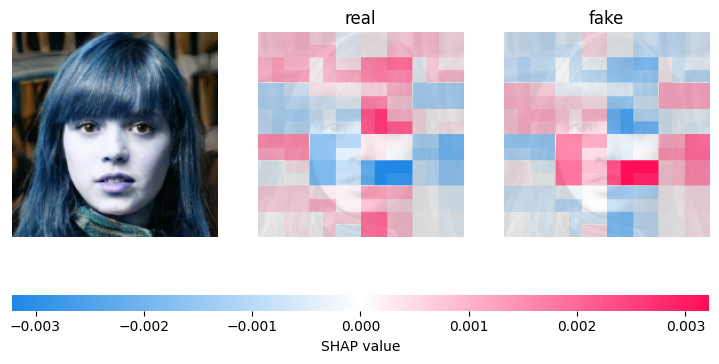

In [ ]:
for i in range(0,26):
  shap_values = explainer(test_data[i:i+1], max_evals=500, outputs=shap.Explanation.argsort.flip[:2])
  shap.image_plot(shap_values)